<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/NN_on_agg_data_with_KMeansSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [4]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [6]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [7]:
del df

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [9]:
del X, Y
gc.collect()

66

In [10]:
sm = KMeansSMOTE()
X_t, y_t = sm.fit_resample(X_train, y_train)

In [11]:
gc.collect()

22

In [12]:
# TensorFlow and tf.keras
import tensorflow as tf

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'])

In [15]:
model.fit(X_t, y_t, epochs=10)

Epoch 1/10
17008/17008 [==============================] - 67s 4ms/step - loss: 0.1687 - accuracy: 0.9281 - auc: 0.9832 - false_negatives: 20107.0000 - false_positives: 19030.0000 - precision: 0.9298 - recall: 0.9261 - true_negatives: 253097.0000 - true_positives: 252020.0000
Epoch 2/10
17008/17008 [==============================] - 62s 4ms/step - loss: 0.1597 - accuracy: 0.9310 - auc: 0.9845 - false_negatives: 18984.0000 - false_positives: 18581.0000 - precision: 0.9316 - recall: 0.9302 - true_negatives: 253546.0000 - true_positives: 253143.0000
Epoch 3/10
17008/17008 [==============================] - 60s 4ms/step - loss: 0.1583 - accuracy: 0.9320 - auc: 0.9849 - false_negatives: 18523.0000 - false_positives: 18463.0000 - precision: 0.9321 - recall: 0.9319 - true_negatives: 253664.0000 - true_positives: 253604.0000
Epoch 4/10
17008/17008 [==============================] - 62s 4ms/step - loss: 0.1555 - accuracy: 0.9325 - auc: 0.9851 - false_negatives: 18469.0000 - false_positives: 1827

In [16]:
test_loss, test_acc, *is_anything_else_being_returned = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)
print('\n Other Metrics ', is_anything_else_being_returned)


2869/2869 - 6s - loss: 0.2274 - accuracy: 0.9016 - auc: 0.9600 - false_negatives: 4750.0000 - false_positives: 4279.0000 - precision: 0.8168 - recall: 0.8006 - true_negatives: 63679.0000 - true_positives: 19075.0000 - 6s/epoch - 2ms/step

Test accuracy: 0.9016266465187073

Test loss: 0.22741350531578064

 Other Metrics  [0.9599729180335999, 4750.0, 4279.0, 0.8167765736579895, 0.8006296157836914, 63679.0, 19075.0]


In [17]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [18]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(63679, 4279, 4750, 19075)

In [20]:
tn, fp, fn, tp

(63679, 4279, 4750, 19075)

In [21]:
f1_score(y_test, y_pred)

0.8086224803408296

In [22]:
roc_auc_score(y_test, y_pred)

0.8688321149038816

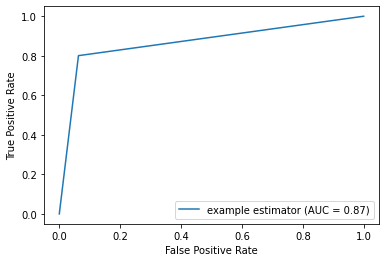

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()